# Final Project Computer Vision
## Truth in Motion: Depth and Flow Enhanced DeepFake Detection

Authors: Aimee Lin, Neli Catar and Gellert Toth

### Imports

In [1]:
!git clone https://github.com/DepthAnything/Depth-Anything-V2.git

Cloning into 'Depth-Anything-V2'...
remote: Enumerating objects: 142, done.
remote: Total 142 (delta 0), reused 0 (delta 0), pack-reused 142 (from 1)
Receiving objects: 100% (142/142), 45.17 MiB | 10.15 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
!mkdir -p DepthAnythingV2Checkpoints
!curl -L https://huggingface.co/depth-anything/Depth-Anything-V2-Base/resolve/main/depth_anything_v2_vitb.pth?download=true --output DepthAnythingV2Checkpoints/depth_anything_v2_vitb.pth


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1138  100  1138    0     0   3793      0 --:--:-- --:--:-- --:--:--  3806
100  371M  100  371M    0     0   314M      0  0:00:01  0:00:01 --:--:--  547M


In [3]:
!git clone https://github.com/sniklaus/pytorch-pwc.git
!mv pytorch-pwc pytorch_pwc

Cloning into 'pytorch-pwc'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 251 (delta 40), reused 62 (delta 24), pack-reused 169 (from 1)
Receiving objects: 100% (251/251), 66.96 MiB | 11.53 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [5]:
!pip install -r requirements.txt --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 130.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import re
import sys
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.transforms as T

from facenet_pytorch import MTCNN
from IPython.display import display
from matplotlib import colors
from PIL import Image, ImageShow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoModel, AutoImageProcessor
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve, auc
import time
from torch.cuda.amp import GradScaler, autocast


depth_anything_path = os.path.abspath("Depth-Anything-V2")

if depth_anything_path not in sys.path:
    sys.path.append(depth_anything_path)
from depth_anything_v2.dpt import DepthAnythingV2

argv_backup = sys.argv
sys.argv = [sys.argv[0]]
from pytorch_pwc.run import estimate
sys.argv = argv_backup

Download data if running in colab

In [3]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Colab Data/'
extract_path = '/content/.'

# Create the destination folder
os.makedirs(extract_path, exist_ok=True)

# Extract
with zipfile.ZipFile(os.path.join(zip_path, "flow_data.zip"), 'r') as zip_ref:
    zip_ref.extractall(extract_path)

with zipfile.ZipFile(os.path.join(zip_path, "depth_data.zip"), 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [7]:
!cp -r '/content/drive/MyDrive/Colab Data/checkpoints' checkpoints

### Globals

In [8]:
# data folders
video_root = './data' # where the data is stored
data_root = './preprocessed_data' # where the pre processed data gets stored
data_flow = "./flow_data" # where flow data gets saved
data_depth = "./depth_data"

# data loading
BATCH_SIZE = 256 # batch size of the preprocessed data

# device
DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(DEVICE)
# training
NUM_EPOCHS = 15 # epochs when training
SKIP_FRAMES = 2 # When processing the video jump some frames to reduce data size


cuda


### Utils

In [9]:
def split_video_into_frames(path, save_path):
    cap = cv2.VideoCapture(path)

    frames = []
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break
        frames.append(frame)

    cap.release()

    faces = [frame_faces for i in range(0, len(frames), BATCH_SIZE) for frame_faces in mtcnn(frames[i:min(len(frames),i+BATCH_SIZE)])]

    os.makedirs(save_path, exist_ok=True)
    for i, frame_faces in enumerate(faces):
        if frame_faces is None:
            continue
        face = frame_faces[0]
        img_pil = Image.fromarray(face.permute(1, 2, 0).numpy().astype(np.uint8))
        img_pil.save(os.path.join(save_path, f"frame_{i}.png"))

def list_leaf_folders(root_dir):
    leaf_folders = []
    for dirpath, dirnames, _ in os.walk(root_dir):
        if not dirnames:
            leaf_folders.append(dirpath)
    return leaf_folders

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def list_sorted_images(folder, extensions={'.png', '.jpg', '.jpeg', '.bmp'}):
    files = [f for f in os.listdir(folder)
             if os.path.isfile(os.path.join(folder, f)) and os.path.splitext(f)[1].lower() in extensions]
    files.sort(key=natural_sort_key)
    return [os.path.join(folder, f) for f in files]

def flow_to_rgb(flow):
    u = flow[..., 0]
    v = flow[..., 1]

    magnitude = np.sqrt(u**2 + v**2)
    direction = np.arctan2(v, u)
    mag_max = np.max(magnitude)
    magnitude = magnitude / mag_max if mag_max != 0 else magnitude

    direction = (direction + np.pi) / (2 * np.pi)
    saturation = magnitude
    value = np.ones_like(magnitude)
    hsv_image = np.stack((direction, saturation, value), axis=-1)
    rgb_image = colors.hsv_to_rgb(hsv_image.astype(np.float32))
    return rgb_image

def calculate_flow_picture(img1, img2):
    res = estimate(img1, img2)
    res = np.array(res.numpy(force=True).transpose(1, 2, 0), np.float32)
    res = flow_to_rgb(res)
    return res

def calculate_depth_picture(model, img):
    res = model.infer_image(img)
    depth_min = np.min(res)
    depth_max = np.max(res)
    if depth_max - depth_min < 1e-6:
        normalised = np.zeros_like(res, dtype=np.uint8)
    else:
        normalised = 255 * (res - depth_min) / (depth_max - depth_min)
        normalised = normalised.astype(np.uint8)
    return normalised

def collect_video_folders(base_dir):
    folders = []
    for root, dirs, _ in os.walk(base_dir):
        for d in dirs:
            folder_path = os.path.join(root, d)
            # check if it contains frames
            if any(fname.lower().endswith(('.jpg', '.png')) for fname in os.listdir(folder_path)):
                folders.append(folder_path)
    return sorted(folders)

def extract_frame_paths_and_labels(base_dirs, label, split_ratio = [0.7, 0.2, 0.1]):
    train_paths = []
    val_paths = []
    test_paths = []

    for base_dir in base_dirs:
        video_folders = collect_video_folders(base_dir)
        total_videos = len(video_folders)

        train_cutoff = int(total_videos * split_ratio[0])
        val_cutoff = int(total_videos * (split_ratio[0] + split_ratio[1]))

        for i, video_folder in enumerate(video_folders):
            frame_paths = glob.glob(os.path.join(video_folder, '*'))
            frame_paths = [f for f in frame_paths if f.lower().endswith(('.jpg', '.png'))]

            labeled = [(fp, label) for fp in frame_paths]

            if i < train_cutoff:
                train_paths.extend(labeled)
            elif i < val_cutoff:
                val_paths.extend(labeled)
            else:
                test_paths.extend(labeled)

    return train_paths, val_paths, test_paths

class FrameDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float32)
        return image, label

def repeat_channels(x):
    if isinstance(x, torch.Tensor) and x.dim() == 3 and x.shape[0] == 1:
        return x.repeat(3, 1, 1)
    elif isinstance(x, torch.Tensor) and x.dim() == 2:
        # Add channel dimension if missing
        return x.unsqueeze(0).repeat(3, 1, 1)
    else:
        raise ValueError(f"Unexpected input shape for repeat_channels: {x.shape}")

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


def train(model, dataloader, criterion, optimizer, device, scale=True):
    model.train()
    if scale:
        scaler = GradScaler()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_probs = []
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            if scale:
                with autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()



        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        preds = probs > 0.5
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).detach().numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

def evaluate(model, dataloader, criterion, device, scale=True):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            if scale:
                with autocast(dtype=torch.float16):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

def plot_training_progress(train_accuracies, val_accuracies, train_aurocs, val_aurocs):
    epochs = range(1, len(train_accuracies)+1)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xticks(list(epochs))
    plt.ylim(0.5, 1.0)

    plt.subplot(1,2,2)
    plt.plot(epochs, train_aurocs, label='Train AUROC')
    plt.plot(epochs, val_aurocs, label='Val AUROC')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.legend()
    plt.title('AUROC')
    plt.xticks(list(epochs))
    plt.ylim(0.5, 1.0)

    plt.tight_layout()
    plt.show()

def train_fp16_distilattion(model_learner, model_teacher, dataloader, criterion, optimizer, device):
    scaler = GradScaler(device)
    model_learner.train()
    model_teacher.train()
    all_labels = []
    all_probs = []
    running_loss = 0.0
    total = 0
    correct = 0

    for images, labels in tqdm.tqdm(dataloader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad()
        with torch.no_grad():
            with autocast(dtype=torch.float16):
                cls_token_teacher = model_teacher(images)
                cls_token_teacher = cls_token_teacher.detach()
        with torch.set_grad_enabled(True):
            with autocast(dtype=torch.float16):
                cls_token_teacher_projected = model_learner.cls_projector(cls_token_teacher)
                cls_token, outputs  = model_learner(images)

                loss = criterion(outputs, labels, cls_token, cls_token_teacher_projected)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

        probs = torch.sigmoid(outputs)
        preds = probs > 0.5
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

        all_labels.append(labels.cpu())
        all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

def evaluate_fp16_distilattion(model_learner, model_teacher, dataloader, criterion, device):
    model_teacher.eval()
    model_learner.eval()
    all_labels, all_probs = [], []
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in tqdm.tqdm(dataloader):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).unsqueeze(1)

            with autocast(dtype=torch.float16):
                cls_token_teacher = model_teacher(images)
                cls_token_teacher = cls_token_teacher.detach()
                cls_token_teacher_projected = model_learner.cls_projector(cls_token_teacher)
                cls_token, outputs = model_learner(images)

                loss = criterion(outputs, labels, cls_token, cls_token_teacher_projected)

            running_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            preds = probs > 0.5
            correct += (preds == labels.bool()).sum().item()
            total += labels.size(0)

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return epoch_loss, epoch_acc, all_labels, all_probs

class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.5, temperature=1.0):
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.bce = nn.BCEWithLogitsLoss()
        self.distill_loss = self._kl_loss

    def forward(self, student_output, labels, student_cls, teacher_cls):
        cls_loss = self.bce(student_output, labels)
        distill = self.distill_loss(student_cls, teacher_cls)
        total_loss = self.alpha * cls_loss + (1 - self.alpha) * distill
        return total_loss

    def _kl_loss(self, student_cls, teacher_cls):
        T = self.temperature
        student_log_probs = F.log_softmax(student_cls / T, dim=-1)
        teacher_probs = F.softmax(teacher_cls / T, dim=-1)
        return F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (T * T)
def prepare_data_loaders(original_sources, manipulated_sources):
    # Collect data
    train_real, val_real, test_real = extract_frame_paths_and_labels(original_sources, label=0)
    train_fake, val_fake, test_fake = extract_frame_paths_and_labels(manipulated_sources, label=1)

    # Combine
    train_data = train_real + train_fake
    val_data = val_real + val_fake
    test_data = test_real + test_fake

    # Sample output
    print(f"Training samples: {len(train_data)}")
    print(f"Testing samples: {len(test_data)}")
    print(f"Sample training item: {train_data[0]}")

    train_dataset = FrameDataset(train_data, transform=image_transform)
    val_dataset = FrameDataset(val_data, transform=image_transform)
    test_dataset = FrameDataset(test_data, transform=image_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader, test_loader

def plot_auc_curve(y_true, y_scores, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def train_full_model(model, original_sources, manipulated_sources, model_name, scale=True):

    train_loader, val_loader, test_loader = prepare_data_loaders(original_sources, manipulated_sources)

    train_accuracies, val_accuracies = [], []
    train_aurocs, val_aurocs = [], []
    epoch_times = []

    start_epoch = 1

    criterion = torch.nn.BCEWithLogitsLoss()
    backbone_params = []
    classifier_params = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            if "backbone" in name:
                backbone_params.append(param)
            else:
                classifier_params.append(param)
    print(len(backbone_params), len(classifier_params))
    optimizer = torch.optim.Adam([
        {"params": backbone_params, "lr": 1e-5},
        {"params": classifier_params, "lr": 1e-4},
    ])
    best_epoch, best_val = -1, 1e9
    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        save_path = os.path.join("checkpoints", f"{model_name}_epoch_{epoch}.pth")
        epoch_start = time.time()

        train_loss, train_acc, train_labels, train_probs = train(model, train_loader, criterion, optimizer, DEVICE, scale)
        val_loss, val_acc, val_labels, val_probs = evaluate(model, val_loader, criterion, DEVICE, scale)

        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
        # AUROC
        train_auroc = roc_auc_score(train_labels, train_probs)
        val_auroc = roc_auc_score(val_labels, val_probs)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_aurocs.append(train_auroc)
        val_aurocs.append(val_auroc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUROC: {train_auroc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUROC: {val_auroc:.4f}")
        print(f"Epoch time: {epoch_time:.2f} seconds")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, save_path)

    plot_training_progress(train_accuracies, val_accuracies, train_aurocs, val_aurocs)
    model_data = torch.load( os.path.join("checkpoints", f"{model_name}_epoch_{best_epoch}.pth"))
    model.load_state_dict(model_data["model_state_dict"])
    start = time.time()
    test_loss, test_acc, test_labels, test_probs = evaluate(model, test_loader, criterion, DEVICE, scale)
    runtime = time.time() - start
    plot_auc_curve(test_labels, test_probs, title=f"AUC Curve, eval done in {runtime:.4f} seconds, accuracy: {test_acc:.4f}")

    torch.save({
        "model_state_dict": model.state_dict()
    }, os.path.join("checkpoints", f"{model_name}_final.pth"))


def train_full_model_distillation(model, teacher_model, original_sources, manipulated_sources, model_name):
    train_loader, val_loader, test_loader = prepare_data_loaders(original_sources, manipulated_sources)

    train_accuracies, val_accuracies = [], []
    train_aurocs, val_aurocs = [], []
    epoch_times = []

    start_epoch = 1

    criterion = DistillationLoss()
    backbone_params = []
    classifier_params = []

    for name, param in model.named_parameters():
        if param.requires_grad:
            if "backbone" in name:
                backbone_params.append(param)
            else:
                classifier_params.append(param)
    print(len(backbone_params), len(classifier_params))
    optimizer = torch.optim.Adam([
        {"params": backbone_params, "lr": 5e-5},
        {"params": classifier_params, "lr": 1e-4},
    ])
    best_epoch, best_val = -1, 1e9
    for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
        save_path = os.path.join("checkpoints", f"{model_name}_epoch_{epoch}.pth")
        epoch_start = time.time()

        train_loss, train_acc, train_labels, train_probs = train_fp16_distilattion(model, teacher_model, train_loader, criterion, optimizer, DEVICE)
        val_loss, val_acc, val_labels, val_probs = evaluate_fp16_distilattion(model, teacher_model, val_loader, criterion, DEVICE)

        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
        # AUROC
        train_auroc = roc_auc_score(train_labels, train_probs)
        val_auroc = roc_auc_score(val_labels, val_probs)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_aurocs.append(train_auroc)
        val_aurocs.append(val_auroc)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch}/{NUM_EPOCHS}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train AUROC: {train_auroc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUROC: {val_auroc:.4f}")
        print(f"Epoch time: {epoch_time:.2f} seconds")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, save_path)

    plot_training_progress(train_accuracies, val_accuracies, train_aurocs, val_aurocs)
    model_data = torch.load( os.path.join("checkpoints", f"{model_name}_epoch_{best_epoch}.pth"))
    model.load_state_dict(model_data["model_state_dict"])
    start = time.time()
    test_loss, test_acc, test_labels, test_probs = evaluate(model, test_loader, criterion, DEVICE)
    runtime = time.time() - start
    plot_auc_curve(test_labels, test_probs, title=f"AUC Curve, eval done in {runtime:.4f} seconds, accuracy: {test_acc:.4f}")

    torch.save({
        "model_state_dict": model.state_dict()
    }, os.path.join("checkpoints", f"{model_name}_final.pth"))


#### Feature extraction generation

In the sections below we tested the feature extraction generation techniques

### Data

Code for downloading the data is based on FaceForensics++ dataset and is available on https://github.com/ondyari/FaceForensics

1. Splitting the videos into frames

In [ ]:
mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device=DEVICE)

for dirpath, _, filenames in os.walk(video_root):
    if len(filenames) == 0:
        continue
    print(f"Processing videos in {dirpath}")
    for file in tqdm(filenames):
        if file.endswith('.mp4'):
            video_path = os.path.join(dirpath, file)
            relative_path = os.path.relpath(video_path, video_root)
            output_folder = os.path.join(data_root, os.path.splitext(relative_path)[0])
            split_video_into_frames(video_path, output_folder)



2. Calculating Optical Flow

In [ ]:
leaf_folders = list_leaf_folders(data_root)
print(leaf_folders)
for folder in tqdm(leaf_folders):
    relative_path = os.path.relpath(folder, data_root)
    images = list_sorted_images(folder)
    images = [torch.FloatTensor(np.ascontiguousarray(np.array(Image.open(image))[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0))) for image in images]
    for i in range(0, len(images)-1, SKIP_FRAMES):
        img1, img2 = images[i], images[i+1]
        res = calculate_flow_picture(img1, img2)
        save_path = os.path.join(data_flow, relative_path)
        os.makedirs(save_path, exist_ok=True)
        rgb_flow_uint8 = (res * 255).astype(np.uint8)
        pil_img = Image.fromarray(rgb_flow_uint8, mode='RGB')
        pil_img.save(os.path.join(save_path, f"flow_image_{i}.png"))

3. Depth Estimation

In [ ]:
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

model = DepthAnythingV2(**model_configs['vitb'])
model.load_state_dict(torch.load(f'DepthAnythingV2Checkpoints/depth_anything_v2_vitb.pth', map_location='cpu'))
model = model.to(DEVICE).eval()


leaf_folders = list_leaf_folders(data_root)
for folder in tqdm(leaf_folders):
    relative_path = os.path.relpath(folder, data_root)
    images = list_sorted_images(folder)
    for i in range(0, len(images), SKIP_FRAMES):
        img_path = images[i]
        img = np.array(Image.open(img_path))
        res = calculate_depth_picture(model, img)
        save_path = os.path.join(data_depth, relative_path)
        os.makedirs(save_path, exist_ok=True)
        pil_img = Image.fromarray(res, mode='L')
        pil_img.save(os.path.join(save_path, f"depth_image_{i}.png"))

100%|██████████| 400/400 [2:57:51<00:00, 26.68s/it]  


### Network

In [10]:
class DinoBinaryClassifier(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone.config.hidden_size, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1, bias=True)  # binary output
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, nonlinearity='relu')
                init.zeros_(layer.bias)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0]
        return self.classifier(cls_token)

#### Flow based network

In [11]:
# Define your paths
original_sources_flow = [
    'flow_data/original_sequences/actors/c23/videos',
    'flow_data/original_sequences/youtube/c23/videos'
]

manipulated_sources_flow = [
    'flow_data/manipulated_sequences/DeepFakeDetection/c23/videos',
    'flow_data/manipulated_sequences/Deepfakes/c23/videos',
    # 'flow_data/manipulated_sequences/Face2Face/c23/videos',
    # 'flow_data/manipulated_sequences/FaceShifter/c23/videos',
    # 'flow_data/manipulated_sequences/FaceSwap/c23/videos',
    # 'flow_data/manipulated_sequences/NeuralTextures/c23/videos'
]

In [ ]:
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
backbone = AutoModel.from_pretrained(model_name)

for param in backbone.parameters():
    param.requires_grad = False

for name, param in backbone.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True

model = DinoBinaryClassifier(backbone)
model.to(DEVICE);

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Training samples: 60365
Testing samples: 10762
Sample training item: ('flow_data/original_sequences/actors/c23/videos/01__hugging_happy/flow_image_192.png', 0)
36 4


100%|██████████| 65/65 [00:38<00:00,  1.70it/s]


Epoch 1/15
Train Loss: 0.7143 | Train Acc: 0.5308 | Train AUROC: 0.5314
Val Loss: 0.6925 | Val Acc: 0.5333 | Val AUROC: 0.5341
Epoch time: 215.68 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 2/15
Train Loss: 0.6850 | Train Acc: 0.5472 | Train AUROC: 0.5619
Val Loss: 0.6922 | Val Acc: 0.5349 | Val AUROC: 0.5462
Epoch time: 218.91 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 3/15
Train Loss: 0.6811 | Train Acc: 0.5594 | Train AUROC: 0.5775
Val Loss: 0.6920 | Val Acc: 0.5494 | Val AUROC: 0.5632
Epoch time: 218.83 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 4/15
Train Loss: 0.6757 | Train Acc: 0.5705 | Train AUROC: 0.5961
Val Loss: 0.6849 | Val Acc: 0.5634 | Val AUROC: 0.5815
Epoch time: 218.80 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 5/15
Train Loss: 0.6687 | Train Acc: 0.5842 | Train AUROC: 0.6164
Val Loss: 0.6930 | Val Acc: 0.5620 | Val AUROC: 0.5814
Epoch time: 218.70 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 6/15
Train Loss: 0.6613 | Train Acc: 0.5952 | Train AUROC: 0.6325
Val Loss: 0.6909 | Val Acc: 0.5752 | Val AUROC: 0.5926
Epoch time: 218.70 seconds


100%|██████████| 65/65 [00:38<00:00,  1.70it/s]


Epoch 7/15
Train Loss: 0.6506 | Train Acc: 0.6109 | Train AUROC: 0.6535
Val Loss: 0.6911 | Val Acc: 0.5698 | Val AUROC: 0.5925
Epoch time: 218.58 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 8/15
Train Loss: 0.6398 | Train Acc: 0.6233 | Train AUROC: 0.6720
Val Loss: 0.6917 | Val Acc: 0.5731 | Val AUROC: 0.5969
Epoch time: 218.83 seconds


100%|██████████| 65/65 [00:38<00:00,  1.70it/s]


Epoch 9/15
Train Loss: 0.6248 | Train Acc: 0.6410 | Train AUROC: 0.6956
Val Loss: 0.7201 | Val Acc: 0.5658 | Val AUROC: 0.5826
Epoch time: 218.59 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 10/15
Train Loss: 0.6065 | Train Acc: 0.6572 | Train AUROC: 0.7196
Val Loss: 0.7259 | Val Acc: 0.5590 | Val AUROC: 0.5785
Epoch time: 218.86 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 11/15
Train Loss: 0.5802 | Train Acc: 0.6785 | Train AUROC: 0.7507
Val Loss: 0.7467 | Val Acc: 0.5613 | Val AUROC: 0.5915
Epoch time: 218.99 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 12/15
Train Loss: 0.5454 | Train Acc: 0.7042 | Train AUROC: 0.7858
Val Loss: 0.8247 | Val Acc: 0.5690 | Val AUROC: 0.5830
Epoch time: 218.70 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 13/15
Train Loss: 0.5056 | Train Acc: 0.7307 | Train AUROC: 0.8208
Val Loss: 0.9000 | Val Acc: 0.5558 | Val AUROC: 0.5698
Epoch time: 218.88 seconds


100%|██████████| 65/65 [00:38<00:00,  1.69it/s]


Epoch 14/15
Train Loss: 0.4559 | Train Acc: 0.7631 | Train AUROC: 0.8580
Val Loss: 0.9687 | Val Acc: 0.5561 | Val AUROC: 0.5737
Epoch time: 218.74 seconds


100%|██████████| 65/65 [00:38<00:00,  1.70it/s]


Epoch 15/15
Train Loss: 0.3974 | Train Acc: 0.7981 | Train AUROC: 0.8943
Val Loss: 1.1866 | Val Acc: 0.5621 | Val AUROC: 0.5728
Epoch time: 218.57 seconds


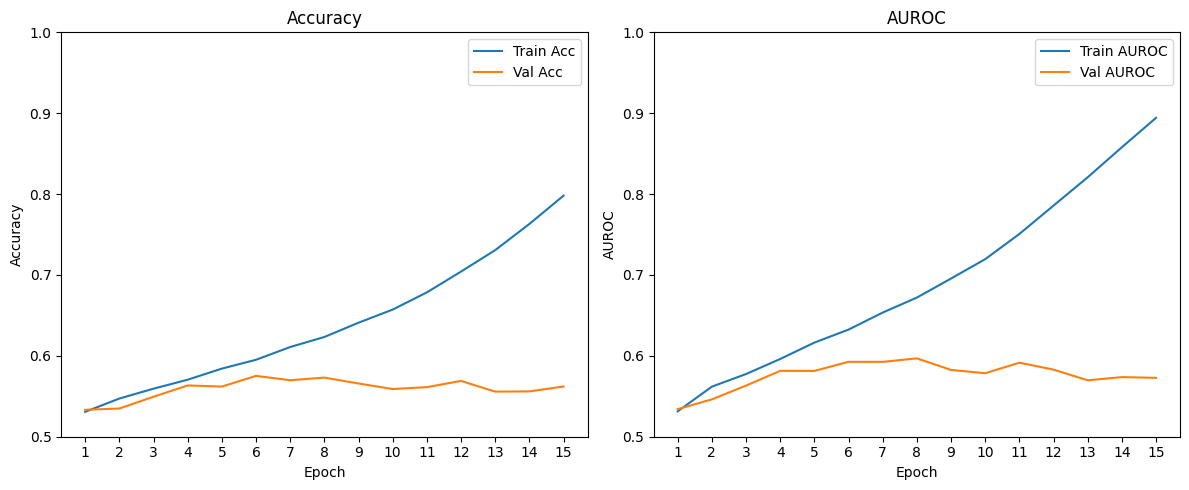

100%|██████████| 43/43 [00:25<00:00,  1.69it/s]


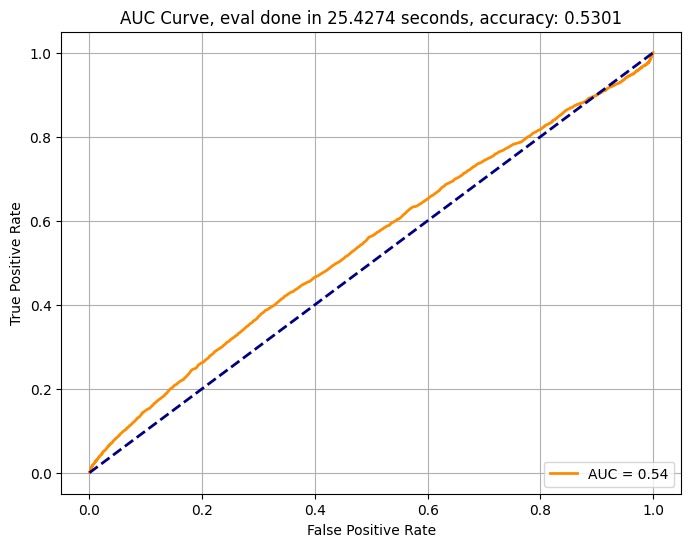

In [ ]:
train_full_model(model, original_sources_flow, manipulated_sources_flow, "flow_dinov2_base_fp16")

#### Depth Based network

In [12]:
# Define your paths
original_sources_depth = [
    'depth_data/original_sequences/actors/c23/videos',
    'depth_data/original_sequences/youtube/c23/videos'
]

manipulated_sources_depth = [
    'depth_data/manipulated_sequences/DeepFakeDetection/c23/videos',
    'depth_data/manipulated_sequences/Deepfakes/c23/videos',
    # 'depth_data/manipulated_sequences/Face2Face/c23/videos',
    # 'depth_data/manipulated_sequences/FaceShifter/c23/videos',
    # 'depth_data/manipulated_sequences/FaceSwap/c23/videos',
    # 'depth_data/manipulated_sequences/NeuralTextures/c23/videos'
]

In [ ]:
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
backbone = AutoModel.from_pretrained(model_name)

for param in backbone.parameters():
    param.requires_grad = False

for name, param in backbone.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True

model = DinoBinaryClassifier(backbone)
model.to(DEVICE)

DinoBinaryClassifier(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale

Training samples: 90617
Testing samples: 16155
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_484.png', 0)
36 4


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 1/15
Train Loss: 0.4065 | Train Acc: 0.8095 | Train AUROC: 0.8965
Val Loss: 0.8566 | Val Acc: 0.6916 | Val AUROC: 0.7707
Epoch time: 327.32 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 2/15
Train Loss: 0.1240 | Train Acc: 0.9505 | Train AUROC: 0.9906
Val Loss: 1.0836 | Val Acc: 0.6913 | Val AUROC: 0.7691
Epoch time: 327.17 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 3/15
Train Loss: 0.0651 | Train Acc: 0.9746 | Train AUROC: 0.9974
Val Loss: 1.1404 | Val Acc: 0.7267 | Val AUROC: 0.8157
Epoch time: 327.19 seconds


100%|██████████| 97/97 [00:56<00:00,  1.70it/s]


Epoch 4/15
Train Loss: 0.0429 | Train Acc: 0.9826 | Train AUROC: 0.9988
Val Loss: 1.3141 | Val Acc: 0.6925 | Val AUROC: 0.7755
Epoch time: 327.21 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 5/15
Train Loss: 0.0312 | Train Acc: 0.9868 | Train AUROC: 0.9994
Val Loss: 1.4001 | Val Acc: 0.6819 | Val AUROC: 0.7641
Epoch time: 327.23 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 6/15
Train Loss: 0.0224 | Train Acc: 0.9902 | Train AUROC: 0.9997
Val Loss: 1.3787 | Val Acc: 0.7137 | Val AUROC: 0.8012
Epoch time: 327.05 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 7/15
Train Loss: 0.0196 | Train Acc: 0.9916 | Train AUROC: 0.9998
Val Loss: 2.3288 | Val Acc: 0.6689 | Val AUROC: 0.7788
Epoch time: 327.26 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 8/15
Train Loss: 0.0167 | Train Acc: 0.9926 | Train AUROC: 0.9998
Val Loss: 1.4743 | Val Acc: 0.6930 | Val AUROC: 0.7750
Epoch time: 327.17 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 9/15
Train Loss: 0.0144 | Train Acc: 0.9935 | Train AUROC: 0.9999
Val Loss: 1.4889 | Val Acc: 0.7102 | Val AUROC: 0.7996
Epoch time: 326.93 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 10/15
Train Loss: 0.0116 | Train Acc: 0.9946 | Train AUROC: 0.9999
Val Loss: 1.6621 | Val Acc: 0.7055 | Val AUROC: 0.8040
Epoch time: 326.66 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 11/15
Train Loss: 0.0142 | Train Acc: 0.9940 | Train AUROC: 0.9999
Val Loss: 1.3583 | Val Acc: 0.7028 | Val AUROC: 0.7924
Epoch time: 326.59 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 12/15
Train Loss: 0.0090 | Train Acc: 0.9960 | Train AUROC: 1.0000
Val Loss: 1.8443 | Val Acc: 0.7028 | Val AUROC: 0.7877
Epoch time: 326.52 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 13/15
Train Loss: 0.0110 | Train Acc: 0.9955 | Train AUROC: 0.9999
Val Loss: 1.8465 | Val Acc: 0.7003 | Val AUROC: 0.7885
Epoch time: 326.49 seconds


100%|██████████| 97/97 [00:57<00:00,  1.70it/s]


Epoch 14/15
Train Loss: 0.0092 | Train Acc: 0.9961 | Train AUROC: 0.9999
Val Loss: 2.0693 | Val Acc: 0.6830 | Val AUROC: 0.7663
Epoch time: 326.27 seconds


100%|██████████| 97/97 [00:56<00:00,  1.70it/s]


Epoch 15/15
Train Loss: 0.0113 | Train Acc: 0.9952 | Train AUROC: 0.9999
Val Loss: 1.7021 | Val Acc: 0.6952 | Val AUROC: 0.7790
Epoch time: 326.29 seconds


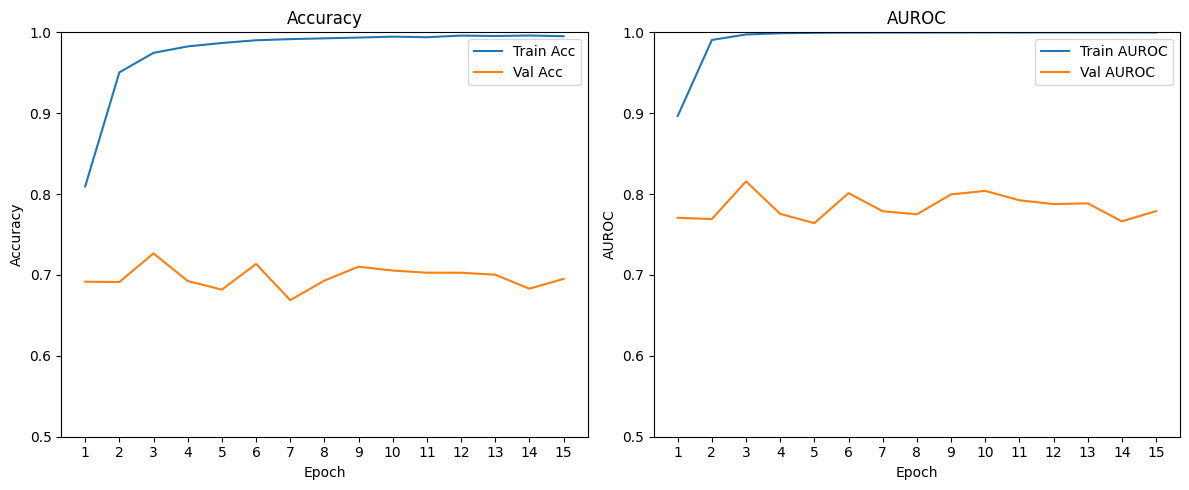

100%|██████████| 64/64 [00:37<00:00,  1.70it/s]


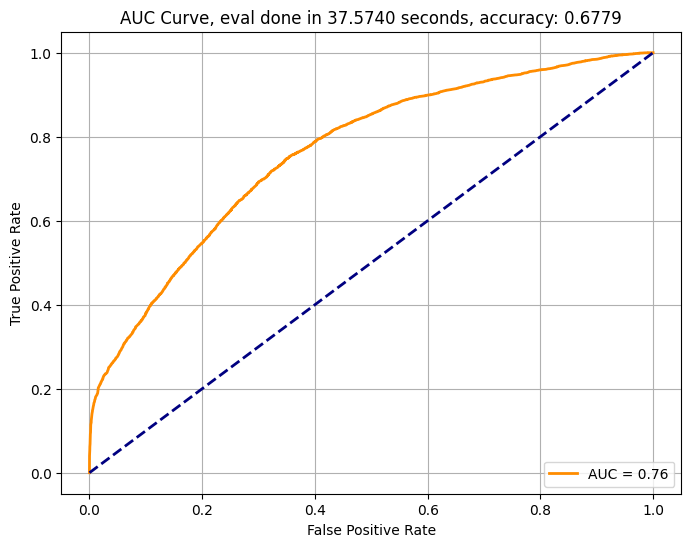

In [ ]:
train_full_model(model, original_sources_depth, manipulated_sources_depth, "depth_dinov2_base_fp16")

### Compression methods

1. Quantization

The models above were trained using fp16 instead of fp32 using autocast. This automatically uses fp16 when it is safe and uses fp32 when it is required. This promises almost no loss in performance while making the model more efficient. To test this we can train a model while turning this feature off.

In [ ]:
model_name = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(model_name)
backbone = AutoModel.from_pretrained(model_name)

for param in backbone.parameters():
    param.requires_grad = False

for name, param in backbone.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True

model = DinoBinaryClassifier(backbone)
model.to(DEVICE)

DinoBinaryClassifier(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale

Training samples: 90617
Testing samples: 16155
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_484.png', 0)
36 4


100%|██████████| 97/97 [02:53<00:00,  1.78s/it]


Epoch 1/15
Train Loss: 0.3802 | Train Acc: 0.8187 | Train AUROC: 0.9080
Val Loss: 0.8002 | Val Acc: 0.7172 | Val AUROC: 0.7890
Epoch time: 967.45 seconds


100%|██████████| 97/97 [02:51<00:00,  1.77s/it]


Epoch 2/15
Train Loss: 0.1142 | Train Acc: 0.9547 | Train AUROC: 0.9919
Val Loss: 1.0361 | Val Acc: 0.7103 | Val AUROC: 0.7804
Epoch time: 966.00 seconds


100%|██████████| 97/97 [02:53<00:00,  1.78s/it]


Epoch 3/15
Train Loss: 0.0608 | Train Acc: 0.9764 | Train AUROC: 0.9977
Val Loss: 1.1020 | Val Acc: 0.7176 | Val AUROC: 0.7906
Epoch time: 967.16 seconds


100%|██████████| 97/97 [02:53<00:00,  1.79s/it]


Epoch 4/15
Train Loss: 0.0409 | Train Acc: 0.9834 | Train AUROC: 0.9989
Val Loss: 1.4624 | Val Acc: 0.6996 | Val AUROC: 0.7701
Epoch time: 966.02 seconds


100%|██████████| 97/97 [02:52<00:00,  1.78s/it]


Epoch 5/15
Train Loss: 0.0322 | Train Acc: 0.9869 | Train AUROC: 0.9993
Val Loss: 1.5593 | Val Acc: 0.7105 | Val AUROC: 0.7763
Epoch time: 965.19 seconds


100%|██████████| 97/97 [02:53<00:00,  1.78s/it]


Epoch 6/15
Train Loss: 0.0215 | Train Acc: 0.9903 | Train AUROC: 0.9997
Val Loss: 1.5224 | Val Acc: 0.7111 | Val AUROC: 0.7832
Epoch time: 966.34 seconds


100%|██████████| 97/97 [02:53<00:00,  1.78s/it]


Epoch 7/15
Train Loss: 0.0204 | Train Acc: 0.9911 | Train AUROC: 0.9997
Val Loss: 1.2317 | Val Acc: 0.7049 | Val AUROC: 0.7830
Epoch time: 965.47 seconds


100%|██████████| 97/97 [02:51<00:00,  1.77s/it]


Epoch 8/15
Train Loss: 0.0168 | Train Acc: 0.9929 | Train AUROC: 0.9998
Val Loss: 1.7549 | Val Acc: 0.7148 | Val AUROC: 0.7842
Epoch time: 963.67 seconds


100%|██████████| 97/97 [02:51<00:00,  1.77s/it]


Epoch 9/15
Train Loss: 0.0161 | Train Acc: 0.9929 | Train AUROC: 0.9998
Val Loss: 1.8684 | Val Acc: 0.7028 | Val AUROC: 0.7703
Epoch time: 963.55 seconds


100%|██████████| 97/97 [02:53<00:00,  1.78s/it]


Epoch 10/15
Train Loss: 0.0113 | Train Acc: 0.9950 | Train AUROC: 0.9999
Val Loss: 2.0887 | Val Acc: 0.6781 | Val AUROC: 0.7547
Epoch time: 964.88 seconds


100%|██████████| 97/97 [02:52<00:00,  1.78s/it]


Epoch 11/15
Train Loss: 0.0121 | Train Acc: 0.9943 | Train AUROC: 0.9999
Val Loss: 1.9951 | Val Acc: 0.6921 | Val AUROC: 0.7674
Epoch time: 963.19 seconds


100%|██████████| 97/97 [02:53<00:00,  1.78s/it]


Epoch 12/15
Train Loss: 0.0126 | Train Acc: 0.9944 | Train AUROC: 0.9999
Val Loss: 2.1893 | Val Acc: 0.6902 | Val AUROC: 0.7585
Epoch time: 964.49 seconds


100%|██████████| 97/97 [02:52<00:00,  1.78s/it]


Epoch 13/15
Train Loss: 0.0107 | Train Acc: 0.9952 | Train AUROC: 0.9999
Val Loss: 1.9969 | Val Acc: 0.7130 | Val AUROC: 0.7858
Epoch time: 964.28 seconds


100%|██████████| 97/97 [02:52<00:00,  1.77s/it]


Epoch 14/15
Train Loss: 0.0104 | Train Acc: 0.9954 | Train AUROC: 0.9999
Val Loss: 2.0727 | Val Acc: 0.6946 | Val AUROC: 0.7721
Epoch time: 962.45 seconds


100%|██████████| 97/97 [02:51<00:00,  1.77s/it]


Epoch 15/15
Train Loss: 0.0119 | Train Acc: 0.9950 | Train AUROC: 0.9999
Val Loss: 2.1441 | Val Acc: 0.6842 | Val AUROC: 0.7525
Epoch time: 962.26 seconds


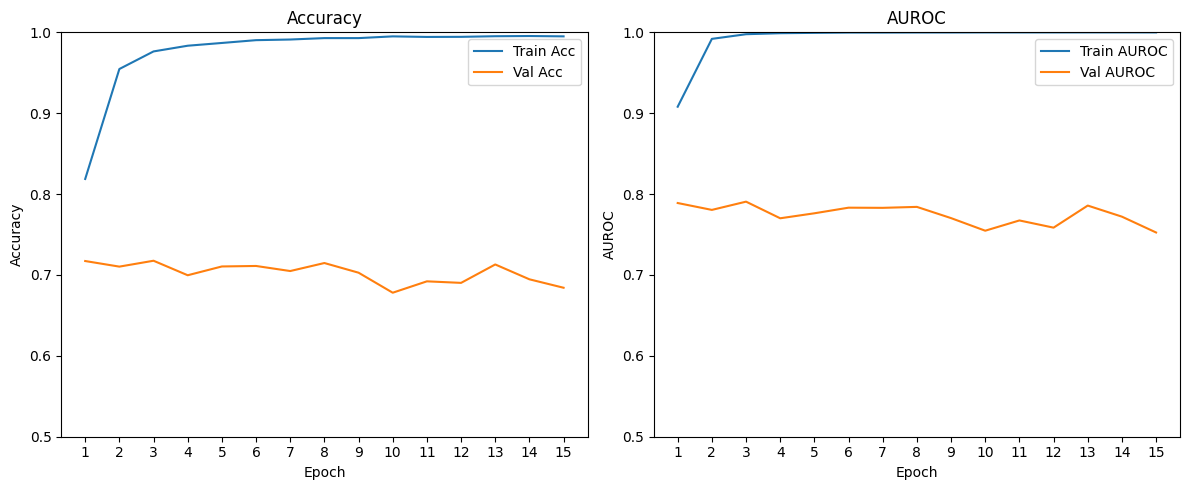

100%|██████████| 64/64 [01:53<00:00,  1.77s/it]


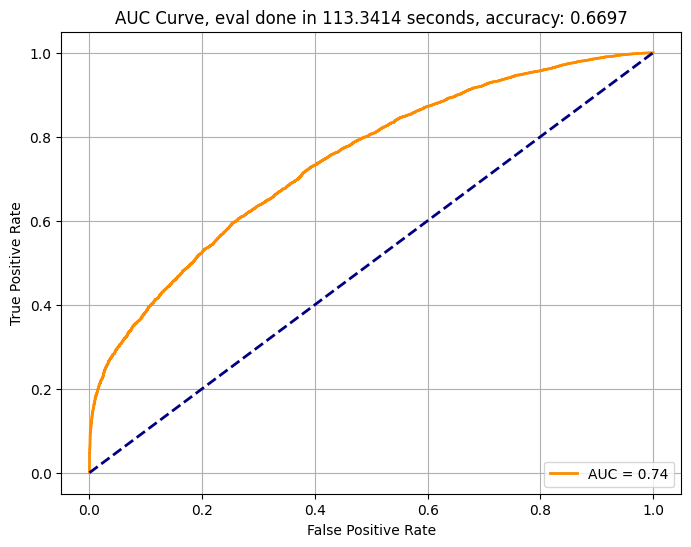

In [ ]:
train_full_model(model, original_sources_depth, manipulated_sources_depth, "depth_dinov2_base_fp32", scale=False)

2. Distillation

In order to test whether distilling a larger model helps we have to train the smaller model by itself first so we have a point of comparison. Then train it again but this time include in the loss the difference between the representations of the learner and teacher model.

In [16]:
model_name = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(model_name)
backbone = AutoModel.from_pretrained(model_name)

for param in backbone.parameters():
    param.requires_grad = False

for name, param in backbone.named_parameters():
    if "encoder.layer.10" in name or "encoder.layer.11" in name:
        param.requires_grad = True

model = DinoBinaryClassifier(backbone)
model.to(DEVICE)

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DinoBinaryClassifier(
  (backbone): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (layer_scale1): Dinov2LayerScale

In [ ]:
train_full_model(model, original_sources_depth, manipulated_sources_depth, "depth_dinov2_small_fp16")

Training samples: 90617
Testing samples: 16155
Sample training item: ('depth_data/original_sequences/actors/c23/videos/01__hugging_happy/depth_image_484.png', 0)
36 4


 94%|█████████▍| 333/354 [01:49<00:06,  3.09it/s]

In [ ]:
class DinoBinaryClassifierForDistilattion(DinoBinaryClassifier):
    def __init__(self, backbone):
        super().__init__(backbone)
        self.cls_projector = nn.Linear(768, 384)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0]
        return cls_token, self.classifier(cls_token)


class DinoBinaryClassifierForDistilattionTeacher(DinoBinaryClassifier):
    def __init__(self, backbone):
        super().__init__(backbone)

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0]
        return cls_token

In [ ]:
base_model_name = "facebook/dinov2-base"
small_model_name = "facebook/dinov2-small"

backbone_base = AutoModel.from_pretrained(base_model_name)
backbone_small = AutoModel.from_pretrained(small_model_name)

for param in backbone_small.parameters():
    param.requires_grad = False

for name, param in backbone_small.named_parameters():
    if "encoder.layer.11" in name or "encoder.layer.10" in name:
        param.requires_grad = True

model_teacher = DinoBinaryClassifierForDistilattionTeacher(backbone_base)
model_teacher.load_state_dict(torch.load('./checkpoints/depth_dinov2_base_fp16_final.pth')["model_state_dict"])
model_teacher.to(DEVICE)

model_learner = DinoBinaryClassifierForDistilattion(backbone_small)
model_learner.to(DEVICE)

In [ ]:
train_full_model_distillation(model_learner, model_teacher, original_sources_flow, manipulated_sources_flow, model_name="flow_dinov2_small_fp16_distilled")

In [ ]:
!cp -r checkpoints '/content/drive/MyDrive/Colab Data/'